In [293]:
import glob, tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torch.optim as optim


import torch.nn.functional as F
from torch.autograd import Variable

import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages")

### Get Dataset

In [269]:
class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, X, y, seq_len=1):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.size = self.seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

In [270]:
stock_ticker = "PLTR"
df = pd.read_csv("{}_out.csv".format(str.lower(stock_ticker)), dtype="float64")
df = df.rename(columns={stock_ticker: 'Stock'})
df.Stock = df.Stock.mask(df.Stock.lt(0),-1)
df.Stock = df.Stock.mask(df.Stock.gt(0),1)

print(df.head(7))

X_data, y_data = df.drop(columns=['Stock']), df.Stock.values
#X_data.head(8)
#y_data[:8]

   Stock    PLTR_vol  PLTR_high   PLTR_low  positive  neutral  negative
0   -1.0  42030900.0  38.009998  34.660000    3771.0   8348.0    3575.0
1   -1.0  43460900.0  35.619999  32.580002     335.0    362.0     187.0
2   -1.0  69647900.0  34.200001  30.500000     704.0    510.0     288.0
3    1.0  35312000.0  32.950001  31.379999     980.0    966.0     697.0
4    1.0  31565000.0  33.180000  31.049999     553.0    877.0     241.0
5    1.0  62375300.0  35.200001  31.750000     644.0   1350.0     604.0
6    1.0  72376000.0  39.220001  35.889999     107.0    110.0      70.0


In [271]:
X = np.where(np.isnan(X_data), float(0.000), X_data)
y = np.where(np.isnan(y_data), float(0.000), y_data)
#X_test = np.where(np.isnan(X_test), 0, X_test)
#y_test = np.where(np.isnan(y_test), 0, y_test)

print(X[:4])

from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X = mm.fit_transform(X)
#y = mm.fit_transform(y.reshape(-1, 1))
#y = y.ravel().tolist()


#dataset = np.hstack((X_trans,y_trans))
print(X[:8])
print(y[:8])

[[4.20309000e+07 3.80099983e+01 3.46599998e+01 3.77100000e+03
  8.34800000e+03 3.57500000e+03]
 [4.34609000e+07 3.56199989e+01 3.25800018e+01 3.35000000e+02
  3.62000000e+02 1.87000000e+02]
 [6.96479000e+07 3.42000008e+01 3.05000000e+01 7.04000000e+02
  5.10000000e+02 2.88000000e+02]
 [3.53120000e+07 3.29500008e+01 3.13799992e+01 9.80000000e+02
  9.66000000e+02 6.97000000e+02]]
[[0.08699905 0.93925689 0.92293572 1.         1.         1.        ]
 [0.09169487 0.81927701 0.81389258 0.08883585 0.04336368 0.05230769]
 [0.17768744 0.74799197 0.70484923 0.18668788 0.06109248 0.08055944]
 [0.06493561 0.68524097 0.75098287 0.25987802 0.11571634 0.19496503]
 [0.05263125 0.69678713 0.73368275 0.14664545 0.1050551  0.06741259]
 [0.15380576 0.79819277 0.77038003 0.17077698 0.16171538 0.16895105]
 [0.18664595 1.         0.987418   0.02837444 0.01317681 0.01958042]
 [0.09426378 0.95155622 1.         0.00371254 0.01173934 0.01006993]]
[-1. -1. -1.  1.  1.  1.  1.  1.]


In [272]:
num_examples = len(X)
num_train = int(num_examples * 0.8)
print(num_train)
X_train = X[:num_train]
y_train = y[:num_train]

X_test = X[num_train:]
y_test = y[num_train:]

my_seq = 4

print(" Length of X_train {0}".format(len(X_train)))
print(" Length of X_test {0}".format(len(X_test)))



train_dataset = TimeseriesDataset(X_train, y_train, seq_len=my_seq)
test_dataset = TimeseriesDataset(X_test, y_test, seq_len=my_seq)

num_examples = len(train_dataset)
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle = False)

109
 Length of X_train 109
 Length of X_test 28


### Set DataLoader

In [273]:
BATCH_SIZE = 1

#num_examples = len(train_dataset)
#print(num_examples)
# why 98%?
#num_train = int(num_examples * 0.8)
#print(num_train)
#train_sampler = SubsetRandomSampler(torch.arange(num_train))

#### TRAIN
train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              #sampler=train_sampler,
                              pin_memory=True,
                              drop_last=False)

#### TEST 
test_dataloader = DataLoader(test_dataset, 
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              #sampler=train_sampler,
                              pin_memory=True,
                              drop_last=False)

print(len(train_dataloader)*BATCH_SIZE)

106


In [274]:
data_test, label_test = next(iter(train_dataloader))
print(y[:11])
print(label_test)
#for ii in range(0, 5):
#    x_features = data_test[ii]
#    y_label = label_test[ii]
#    y_orig = y
#    print("Day {0}: My features \n {1}, \n \t Label {2}, Orig {3} ".format(ii, x_features,y_label,y_orig))

[-1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1.]
tensor([1.], dtype=torch.float64)


### Set Model

In [275]:
class LSTM_Model(nn.Module):
    def __init__(self, 
                 input_size, 
                 output_size,
                 hidden_size=128):
        
        super(LSTM_Model, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.lstm   = nn.LSTM(self.input_size, 
                              self.hidden_size,
                              batch_first=True, 
                              num_layers=1) # If this is >1, this changes the output shape, FYI
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(
            1, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            1, x.size(0), self.hidden_size))
        
        x, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        h_out = h_n.view(-1, self.hidden_size)
        x = self.linear(h_out)
        
        #x, _ = self.lstm(x)
        #x = self.linear(x.squeeze)
        
        return x

In [276]:
def train(epochs, optimizer, criterion, device, train_dataloader, model):
    # See what the scores are before training
    # Note that element i,j of the output is the score for tag j for word i.
    # Here we don't need to train, so the code is wrapped in torch.no_grad()
    #model = model.float()
    #data_test, label_test = next(iter(train_dataloader))
    #with torch.no_grad():
    #   tag_scores = model(data_test)
    #    print(tag_scores)
    
    #model.train(True)
    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        running_loss=0
        model.train(True)# (True)
        for i, data in enumerate(train_dataloader):
            # Every data instance is an input + label pair
            inputs, labels = data

            # Make predictions for this batch
            
            #print("my inputs")
            #print(inputs.dtype)
            #print(" my labels ")
            #print(labels.dtype)
            
            outputs = model(inputs.float())
            # Zero your gradients for every batch!
            optimizer.zero_grad()
            
            # Compute the loss and its gradients
            loss = criterion(outputs.squeeze(), labels.float().squeeze())
            #print(loss.dtype)
            loss.backward()

            # Adjust learning weights
            optimizer.step()
            running_loss += loss.item()
            
        if epoch % 10 == 0:
            print("output are ")
            print(outputs.squeeze())
            ##print("inputs are ")
            #print(inputs)
            print(" labels are below ")
            print(labels.shape)
        print(" Epoch {0}, train loss {1}".format(epoch, running_loss))
        running_loss=0
        

In [279]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight_file = "LSTM_Model.pt"

num_epochs = 250
learning_rate = 0.001

input_size = 6
hidden_size = 128
output_size = 1

model = LSTM_Model(input_size = input_size,  output_size = output_size)
model.to(device)

criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train Model

In [280]:
train(
    epochs=num_epochs,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    train_dataloader=train_dataloader,
    model=model
)

EPOCH 1:
output are 
tensor(-0.0221, grad_fn=<SqueezeBackward0>)
 labels are below 
torch.Size([1])
 Epoch 0, train loss 107.84519920963794
EPOCH 2:
 Epoch 1, train loss 105.81401822413318
EPOCH 3:
 Epoch 2, train loss 105.31067628925666
EPOCH 4:
 Epoch 3, train loss 105.04607547260821
EPOCH 5:
 Epoch 4, train loss 104.83799448003992
EPOCH 6:
 Epoch 5, train loss 104.6488992664963
EPOCH 7:
 Epoch 6, train loss 104.41145580168813
EPOCH 8:
 Epoch 7, train loss 104.02817490743473
EPOCH 9:
 Epoch 8, train loss 102.64293468487449
EPOCH 10:
 Epoch 9, train loss 100.34556796896504
EPOCH 11:
output are 
tensor(-0.0211, grad_fn=<SqueezeBackward0>)
 labels are below 
torch.Size([1])
 Epoch 10, train loss 100.80431125994073
EPOCH 12:
 Epoch 11, train loss 95.94316172867548
EPOCH 13:
 Epoch 12, train loss 97.99231454671826
EPOCH 14:
 Epoch 13, train loss 93.95302835130133
EPOCH 15:
 Epoch 14, train loss 95.32355848955922
EPOCH 16:
 Epoch 15, train loss 91.78666738804895
EPOCH 17:
 Epoch 16, train 

In [281]:
my_model_results=[]
print(len(train_dataloader))
for i, data in enumerate(train_dataloader):
    # Every data instance is an input + label pair
    inputs, labels = data
    
    outputs = model(inputs.float())
    results = outputs.cpu().detach().numpy()
    #my_model_results.append(results[0][0])
    #print(results.shape)
    my_model_results.append(results)
    
my_res = [ 1 if xx[0] > 0 else -1 for xx in my_model_results]


106


In [282]:
my_test_results=[]
print(len(test_dataloader))
model.train(False)

for i, data in enumerate(test_dataloader):
    # Every data instance is an input + label pair
    inputs, labels = data
    
    outputs = model(inputs.float())
    results = outputs.cpu().detach().numpy()
    #my_model_results.append(results[0][0])
    #print(results.shape)
    my_test_results.append(results)
    
my_test_res = [ 1 if xx[0] > 0 else -1 for xx in my_test_results]

print(len(my_test_res))

25
25


In [283]:
def getAcc(l1, l2):
    matches = 0
    no_matches = 0
    print(len(l1))
    print(len(l2))
    for ii, ee in enumerate(list(zip(l1,l2))):
        l1_element = ee[0]
        l2_element = ee[1]
        if l1_element < 0 and l2_element < 0:
            matches+=1
        elif l1_element > 0 and l2_element > 0:
            matches+=1
        else:
            no_matches+=1
    acc = matches/len(l1)  
    miss = no_matches/len(l1)
    return acc, miss

25


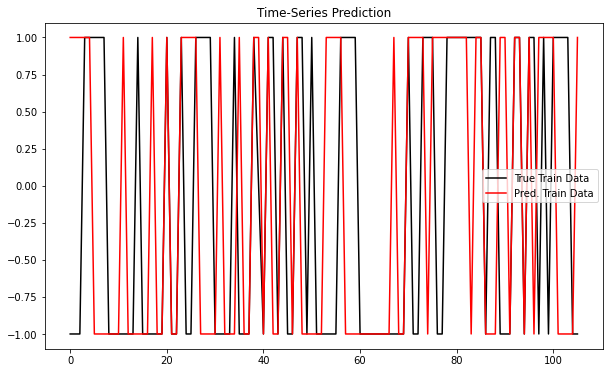

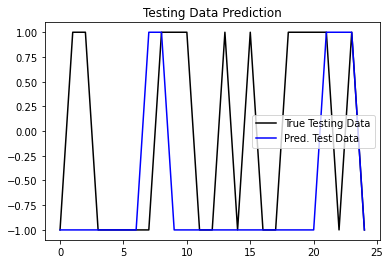

In [284]:
data_predict = np.array(my_res).reshape(-1,1) # numpy conversion
dataY_train_plot = np.array(y_train).reshape(-1,1)
dataY_test_plot = np.array(y_test).reshape(-1,1)

data_test_predict = np.array(my_test_res).reshape(-1,1) # numpy conversion
print(len(data_test_predict))


#data_predict = mm.inverse_transform(data_predict) # reverse transformation
#dataY_plot = mm.inverse_transform(dataY_plot)

true_test, true_train, preds, test = [], [], [], []

for i in range(len(dataY_train_plot)):
    true_train.append(dataY_train_plot[i][0])
    
for i in range(len(dataY_test_plot)):
    true_test.append(dataY_test_plot[i][0])
    
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
    
for i in range(len(data_test_predict)):
    test.append(data_test_predict[i][0])

plt.figure(figsize=(10,6)) #plotting


true_diff = np.diff(true_train)
true_test_diff = np.diff(true_test)
preds_diff = np.diff(preds)
test_diff = np.diff(test)

plt.plot(true_train[:-my_seq+1], label='True Train Data',c='k') # actual plot
plt.plot(preds, label='Pred. Train Data',c='r') # predicted plot

#print(preds)
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("{0}_training_nn.png".format(stock_ticker), dpi=300)
plt.show() 

plt.title("Testing Data Prediction")
plt.plot(true_test[:-my_seq+1], label='True Testing Data',c='k') # predicted plot
plt.plot(test, label='Pred. Test Data',c='b') # predicted plot
plt.legend()
plt.savefig("{0}_test_nn.png".format(stock_ticker),dpi=300)
plt.show()

In [285]:
#num_examples
print(" true lenght ",len(true_test))
print (" true train len ", len(true_train))
print (" true test len ", len(true_test))

 true lenght  28
 true train len  109
 true test len  28


In [289]:
train_acc, train_miss = getAcc(true_train[:-my_seq+1], preds)

106
106


In [290]:
print(acc, " ", train_miss)

0.5754716981132075   0.4339622641509434


In [291]:
test_acc, test_miss = getAcc(true_test[:-my_seq+1], test)

25
25


In [292]:
print(test_acc, " ", test_miss)

0.56   0.44
